## This an experiment for prediction of flats' prices.
## It tests out the impact on the metrics of the following aspects:


* Feature engineering 
* Feature selection with Sequential Feature Selection algorithms
* Hyperparameter selection for predicting flats prices

Steps:
1. Read data
2. Clean data
3. Perform EDA
4. Perform feature engineering with transformers and autofeat library
5. Select features with Sequential Forward Selection (SFS) alogrithm
6. Select hyperparameters with RandomizedSearchCV and Optuna
7. Train the RandmomizedForestRegressor model on the selected features, dataset and hyperparameters

In [1]:
from IPython.display import clear_output
!pip install psycopg psycopg_binary mlxtend optuna

clear_output()

In [2]:
import numpy as np
import mlxtend
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import optuna
import pandas as pd
import psycopg
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, MinMaxScaler, PolynomialFeatures

import logging
logging.getLogger().setLevel(logging.ERROR)
import warnings

# Suppress all warnings in cells printouts for clear output

warnings.filterwarnings('ignore')

from kaggle_secrets import UserSecretsClient

RANDOM_STATE=42

# 1. Read Data

In [3]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("AWS_ACCESS_KEY_ID")
secret_value_1 = user_secrets.get_secret("AWS_SECRET_ACCESS_KEY")
secret_value_2 = user_secrets.get_secret("DB_DESTINATION_HOST")
secret_value_3 = user_secrets.get_secret("DB_DESTINATION_NAME")
secret_value_4 = user_secrets.get_secret("DB_DESTINATION_PASSWORD")
secret_value_5 = user_secrets.get_secret("DB_DESTINATION_PORT")
secret_value_6 = user_secrets.get_secret("DB_DESTINATION_USER")
secret_value_7 = user_secrets.get_secret("DB_SOURCE_HOST")
secret_value_8 = user_secrets.get_secret("DB_SOURCE_NAME")
secret_value_9 = user_secrets.get_secret("DB_SOURCE_PASSWORD")
secret_value_10 = user_secrets.get_secret("DB_SOURCE_PORT")
secret_value_11 = user_secrets.get_secret("DB_SOURCE_USER")
secret_value_12 = user_secrets.get_secret("S3_BUCKET_NAME")


TABLE_NAME = 'clean_flat_price_predict'

RANDOM_STATE = 42

connection = {'sslmode': 'require', 'target_session_attrs': 'read-write'}
postgres_credentials = {
    'host': secret_value_2,
    'port': secret_value_5,
    'dbname': secret_value_3,
    'user': secret_value_6,
    'password': secret_value_4,
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]


df = pd.DataFrame(data, columns=columns)

df.head()

,id,flat_id,building_id,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,target
0,802,0.0,6220.0,9,0,9.9,19.900000,1,0,35.099998,1965,6,55.717113,37.781120,2.64,84,12,1,9500000
1,804,2.0,17821.0,9,0,9.0,32.000000,2,0,56.000000,2000,4,55.740040,37.761742,2.70,80,10,1,13500000
2,805,3.0,18579.0,1,0,10.1,43.099998,3,0,76.000000,2002,4,55.672016,37.570877,2.64,771,17,1,20000000
3,806,4.0,9293.0,3,0,3.0,14.000000,1,0,24.000000,1971,1,55.808807,37.707306,2.60,208,9,1,5200000
4,807,5.0,23964.0,9,0,0.0,0.000000,2,0,51.009998,2017,4,55.724728,37.743069,2.70,192,17,1,8490104


In [4]:
df.shape

(720, 19)

In [5]:
df.dtypes

id                     int64
flat_id               object
building_id           object
floor                  int64
is_apartment           int64
kitchen_area         float64
living_area          float64
rooms                  int64
studio                 int64
total_area           float64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator           int64
target                 int64
dtype: object

**Outcome:** From the pre-knowledge about this dataset, 'target' is the flat price. 'flat_id' and 'building_id' marked as object indicate there is mixed datatypes in the id cells.

# 2. Clean data

In [6]:
# Since I have some pre-knowledge on this specific dataset, I am performing only necessary steps

df = df.drop_duplicates(subset='flat_id', keep='first')

df['is_apartment'] = df['is_apartment'].astype(int)
df['studio'] = df['studio'].astype(int)
df['has_elevator'] = df['has_elevator'].astype(int)


# remove duplicates

feature_cols = df.columns.drop('flat_id').tolist()
is_duplicated_features = df.duplicated(subset=feature_cols, keep=False)
df = df[~is_duplicated_features].reset_index(drop=True)


# fill missing values

cols_with_nans = df.isnull().sum()
if cols_with_nans.any():
    cols_with_nans = cols_with_nans[cols_with_nans > 0] # names of NaN containing columns
    cols_with_nans.index.drop('target') if 'target' in cols_with_nans.index else cols_with_nans.index
    for col in cols_with_nans:
        if df[col].dtype in [float, int]:
            fill_value = df[col].mean()
        elif df[col].dtype == 'object':
            fill_value = df[col].mode().iloc[0]

        df[col] = df[col].fillna(fill_value)


In [7]:
df.describe()

,id,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,target
count,720.000000,720.000000,720.0,720.000000,720.000000,720.000000,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.00000,7.200000e+02
mean,1304.434722,6.901389,0.0,7.887472,27.986514,1.884722,0.0,49.497014,1985.938889,3.868056,55.717897,37.595806,2.664931,258.130556,13.497222,0.93750,1.098631e+07
std,287.234797,4.745542,0.0,2.958021,11.851082,0.813167,0.0,14.551181,18.255996,1.106603,0.109673,0.156667,0.041003,172.139897,4.770096,0.24223,3.767515e+06
min,802.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.0,17.670000,1959.000000,0.000000,55.474884,37.206253,2.600000,36.000000,5.000000,0.00000,3.690245e+06
25%,1060.750000,3.000000,0.0,6.000000,19.000000,1.000000,0.0,38.000000,1970.000000,4.000000,55.629917,37.490540,2.640000,128.000000,9.000000,1.00000,8.300000e+06
50%,1305.500000,6.000000,0.0,8.300000,28.100000,2.000000,0.0,45.000000,1981.000000,4.000000,55.700695,37.585960,2.640000,214.000000,14.000000,1.00000,1.020000e+07
75%,1552.500000,10.000000,0.0,10.000000,34.849999,2.000000,0.0,59.000000,2002.250000,4.000000,55.810643,37.702586,2.700000,340.500000,17.000000,1.00000,1.300000e+07
max,1801.000000,25.000000,0.0,16.000000,56.000000,4.000000,0.0,91.000000,2020.000000,6.000000,56.009346,37.941315,2.780000,1112.000000,26.000000,1.00000,3.000000e+07


**Outcome:** 'studio' and 'is_apartment' have min == max == std == 0 and thus can be removed

In [8]:
# remove non informative features

df.drop(['id', 'building_id', 'flat_id', 'studio', 'is_apartment'], inplace=True, axis = 1)

In [9]:
# group feature columns by type

cat_cols = ['rooms', 'building_type_int', 'has_elevator']
num_cols = df.select_dtypes(['float', 'int']).columns.tolist() 
columns_to_remove = cat_cols + ['target']
num_cols = [col for col in num_cols if col not in columns_to_remove]

# 3. Perform EDA

In [10]:
# Check for outliers.
# Display all numerical features on one boxplot using scaler for clean comparative output

def show_scaled_boxplot(df):
    cols = df.columns
    min_max_scaler = MinMaxScaler()
    df_boxplot = df[cols].copy()
    df_boxplot = min_max_scaler.fit_transform(df_boxplot)
    df_boxplot = pd.DataFrame(df_boxplot, columns=min_max_scaler.get_feature_names_out())

    sns.boxplot(data=df_boxplot)
    plt.xticks(ticks=range(len(cols)), labels=df_boxplot.columns,rotation=45, ha='right')  
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tight_layout()
    plt.show()

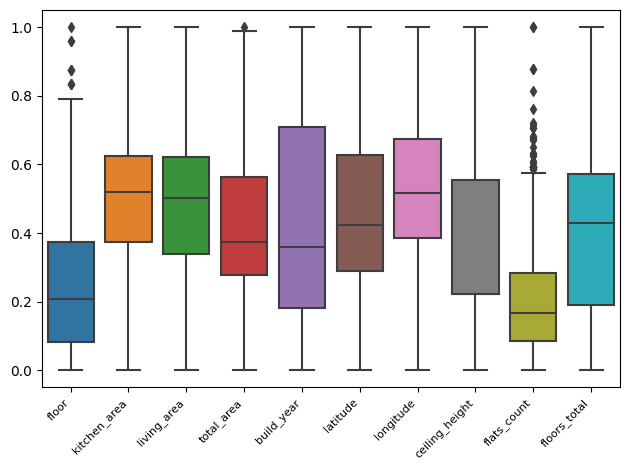

In [11]:
show_scaled_boxplot(df[num_cols])

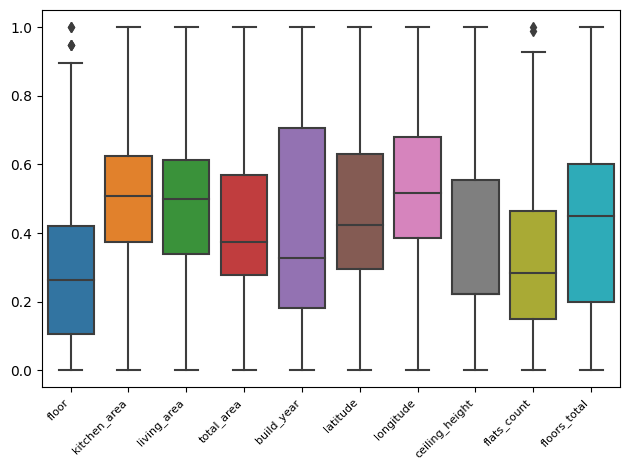

In [12]:
# Remove outliers on the original dataset

threshold = 1.5
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    margin = threshold * IQR
    lower = Q1 - margin
    upper = Q3 + margin
    mask = df[col].between(lower, upper)
    df = df[mask]


# Checking if outliers reduced

show_scaled_boxplot(df[num_cols])

**Outcome:**
Outliers reduced. We see a median in some of the boxplots deviating from the mean, showing that the data distribution is somewhat skewed. 'build_year' and 'floors_total' large box size indicate a larger variety of the data.

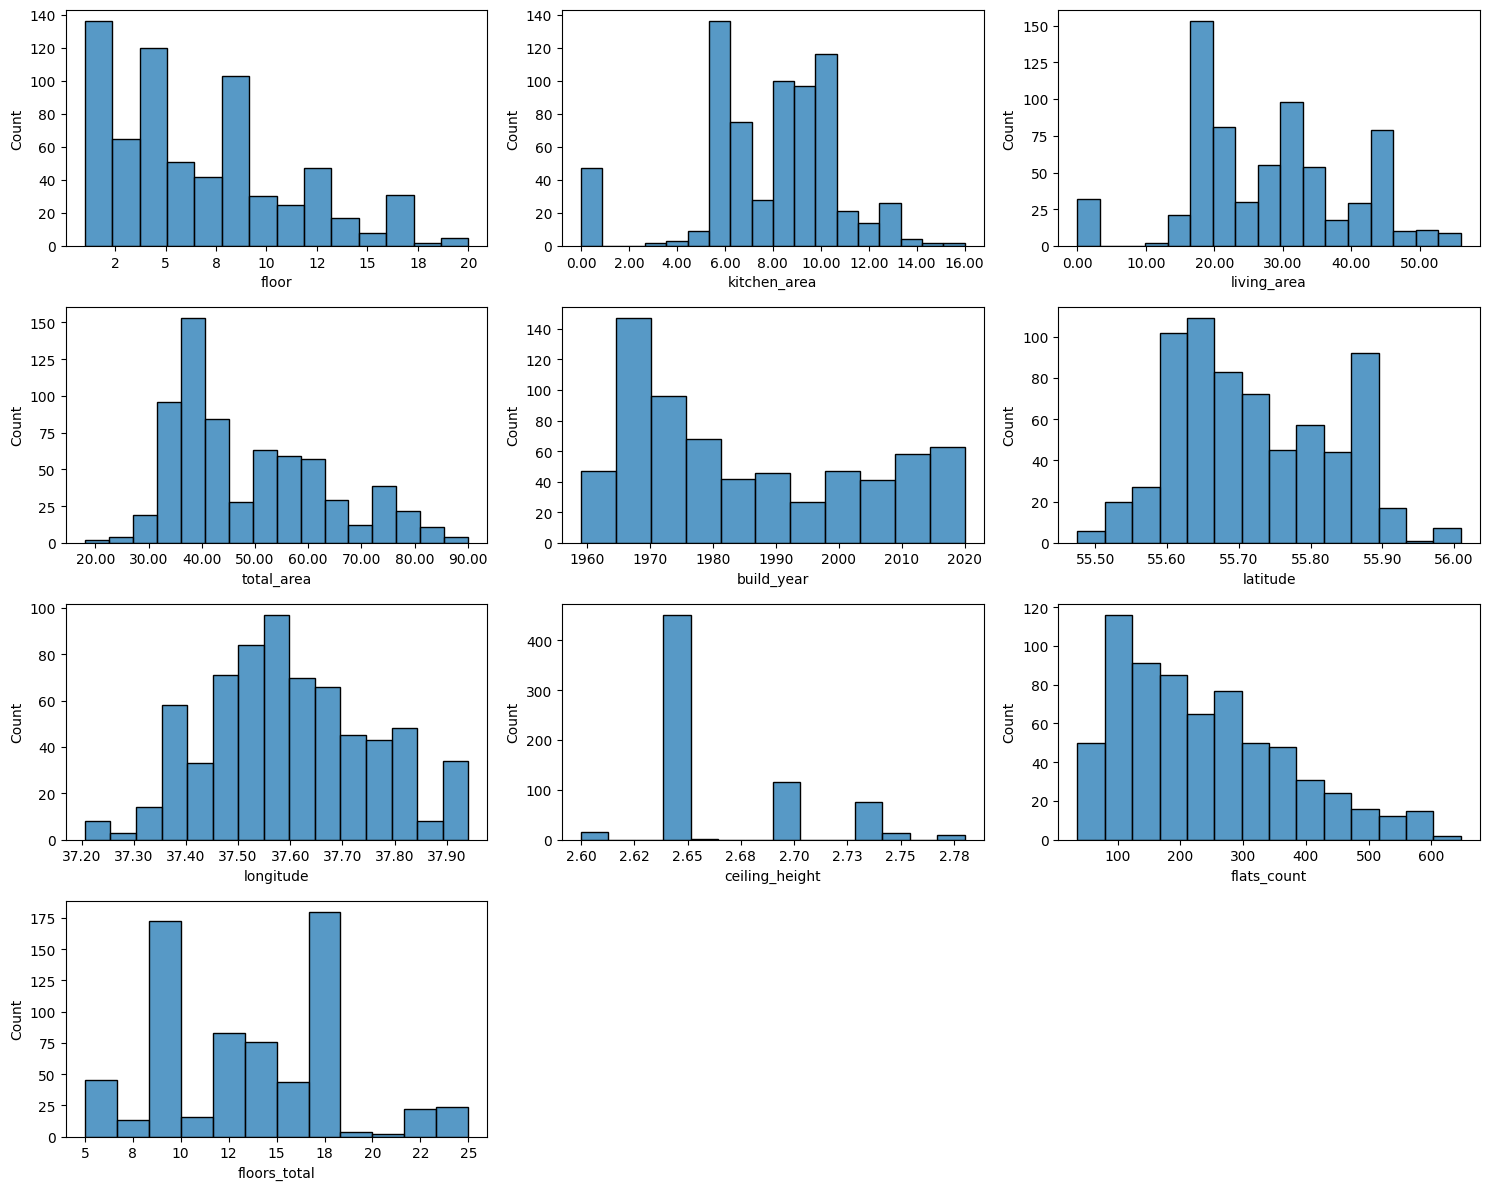

In [13]:
# Analysis of numerical features distributions

n_cols = 3  
n_rows = (len(num_cols) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))


axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i])
    if df[col].dtype == 'int64':
        axes[i].xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:.0f}"))
    else:
        axes[i].xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:.2f}"))
    axes[i].set_xlabel(col)

# Clean unused empty subplots

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Outcome:** From the pre-knowledge of the dataset, 'longitute' and 'latitude' are where the buildings are located. 'kitchen_area', 'ceiling_height' show more typical areas and heights of the flats to stand out. Overall skewed distributions.

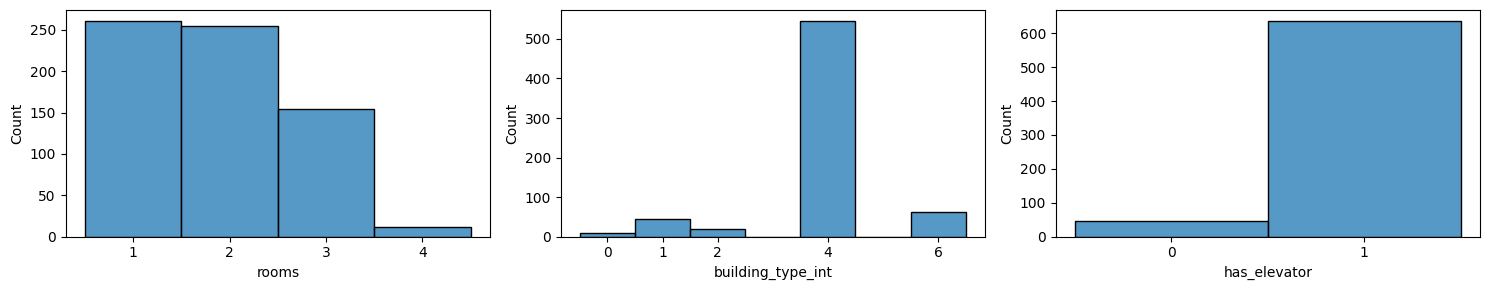

In [14]:
# Analysis of categorical features distribution

n_cols = 3  
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))

axes = axes.flatten()

for i, col in enumerate(cat_cols):
    unique_vals = sorted(df[col].unique()) # needed for discrete values to show whole, not float numbers on categ. axes
    sns.histplot(df[col], ax=axes[i], discrete=True, bins=len(unique_vals))
    axes[i].set_xticks(unique_vals)  
    axes[i].set_xlabel(col)

# Clean empty subplots

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Outcome:** Lots of appartments with 1-2 rooms, and building type 4. Most datapoints have an elevator, model might predict better for these types as sees less flats without.

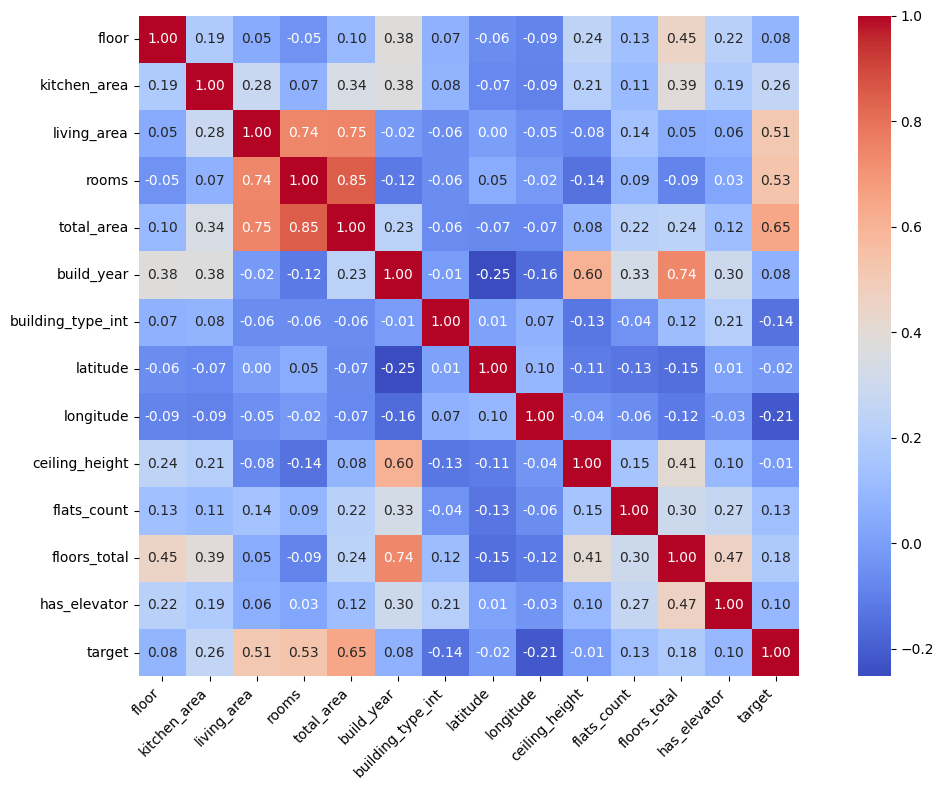

In [15]:
# Check for correlation between features

correlation_matrix = df.corr()
plt.figure(figsize=(12, 8)) 
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

**Outcome:** The total_area correlates with the target variable (flat price) obviously; 

The correlation between the year of construction and the number of floors in the building looks logical: it might be a certain architectural trend.

The price (target) strongly correlates with the number of rooms, total area, and living room; this means these features are important to us. However the rooms correlate strongly with the area, so it's better to get rid of them. Though we will not use a direct linear regression model (to be able to tune hyperparameters for the sake of the excercise), it is still helpful to remove inner correlation of the features.

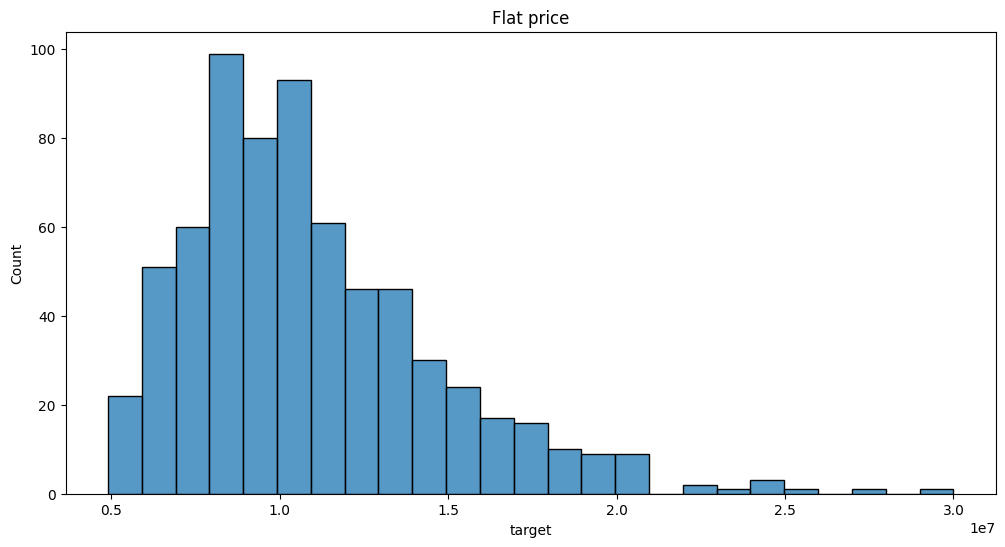

In [16]:
# Analysis of the target variable - the flats price.

fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(df['target'])
ax.set_title('Flat price')
ax.set_xlabel('target')
plt.show()

**Outcome:** Skewed distribution with most popular price around 1M.

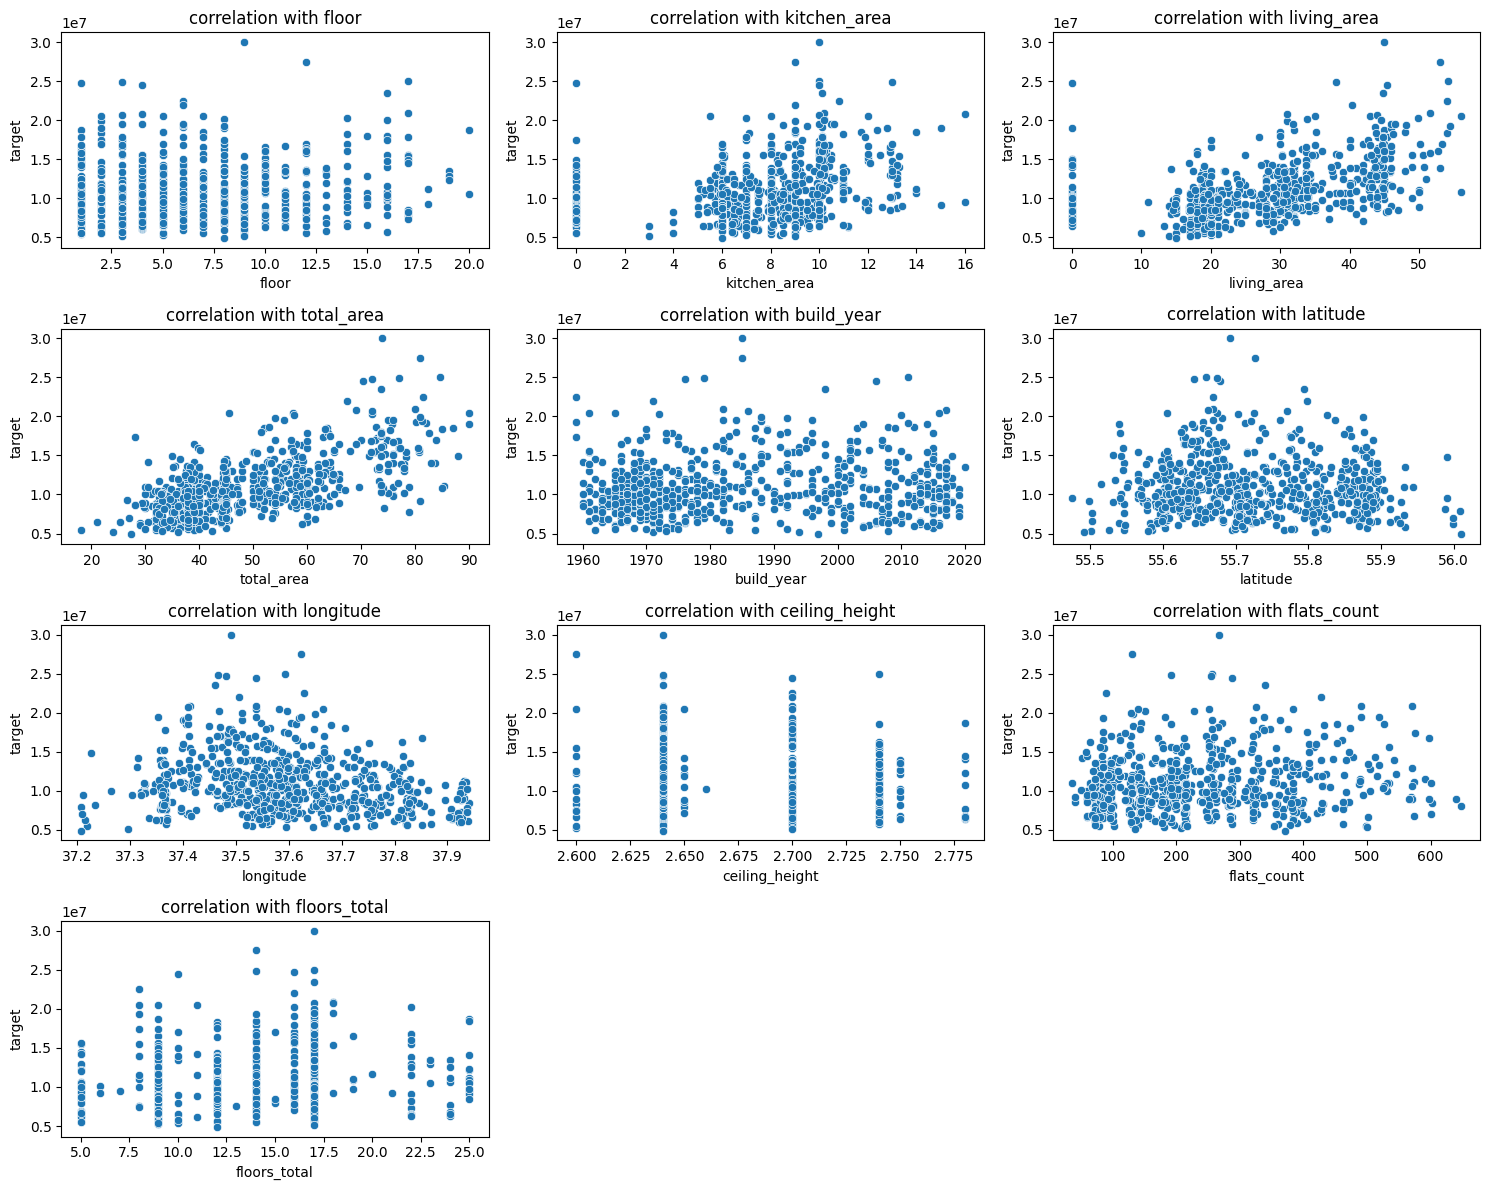

In [17]:
# Analysis of a relation between numerical features and the target variable

n_cols = 3  
n_rows = (len(num_cols) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.scatterplot(x=col, y='target', data=df,  ax=axes[i])
    axes[i].set_title(f'correlation with {col}')
    axes[i].set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Outcome:** As seen in the correlation matrix, area-related variables strongly correlate with the target variable. Features like floors and ceiling height variety is pretty even with exception of some outliers in the target variable. Latitude and Longitude as well do not add a lot of infomration, so we do not have too many features and some feature engineering might be helpful. 

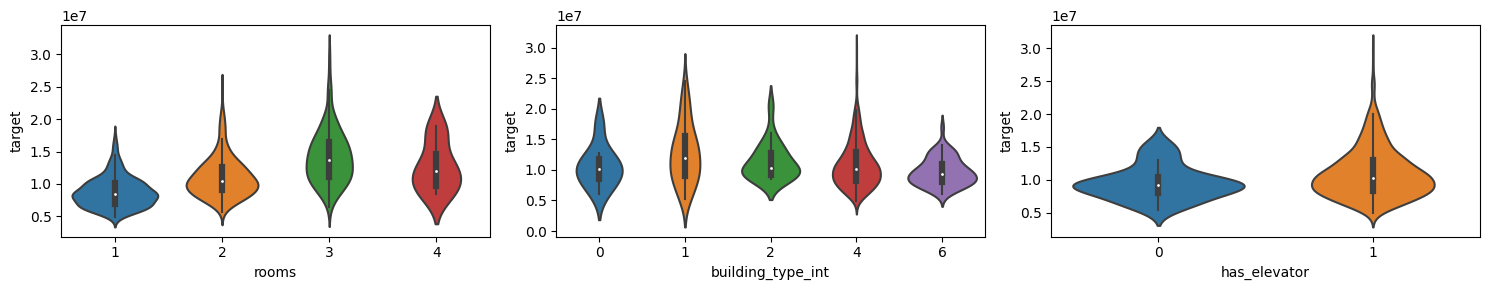

In [18]:
# Analysis of a relation between categorical features and the target variable

n_cols = 3  
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
axes = axes.flatten() 

for i, col in enumerate(cat_cols):
    sns.violinplot(x=df[col].astype('category'), y='target', data=df, ax=axes[i])
    axes[i].set_xlabel(col)
    

for j in range(i + 1, len(axes)):
    axes[j].remove()  

plt.tight_layout()
plt.show()

**Outcome:**  I have chosen a violin plot vs boxplot here to make the target variable distribution more illustrative (matter of taste). As already seen, 'studio' and 'is_apartment' are not informative and will be removed. Growing rooms number increases the price median until it reaches 4 rooms and drops. Seems like price grows from room 1 to 3 and then does not. The density of the price data points is very much between 1 and 1.5M.

In [19]:
# Eliminate mutually correlating features

df.drop(['rooms', 'living_area'], inplace=True, axis = 1)

In [20]:
# Eliminate the names of the non-informative featrues from column names for further operations

num_cols.remove('living_area')
cols_to_remove = ('rooms')  # Convert to set for efficiency
cat_cols = [item for item in cat_cols if item not in cols_to_remove]

### Try out the model on the cleaned but not transformed dataset and compare the metrics:
Model to be used: RandomForestRegressor. Chosen for good dealing with regression tasks and having hyperparameters to tune.

In [21]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# initalization of metrics dictionary to collect along the expetiment

rmse_metrics = {}  
mape_metrics = {}

In [22]:
# Define functions for displaying metrics

def display_metrics(metrics, title):
    for name, val in metrics.items():
        print(f'{name}: {val:.2f}')    
    plt.figure(figsize=(8, 4))
    plt.plot(list(metrics.keys()), list(metrics.values())),
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('Value')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def calculate_rmse(y_test, predictions):
    mse = np.mean((y_test - predictions) ** 2)
    return np.sqrt(mse)

def calculate_mape(y_test, predictions):
    y_test, predictions = np.array(y_test), np.array(predictions)
    mask = y_test != 0
    return (np.fabs(y_test - predictions) / y_test)[mask].mean() * 100

In [23]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)

rmse = calculate_rmse(y_test, prediction)
mape = calculate_mape(y_test, prediction)

rmse_metrics['rmse initial'] = rmse
mape_metrics['mape initial'] = mape

print('rmse initial:', rmse)
print('mape initial:', mape)

rmse initial: 2521821.691088597
mape initial: 17.69701418453172


# 4. Feature engineering

In [24]:
n_bins = 5
degree = 3

def to_dataframe(X, ct):
    return pd.DataFrame(X, columns=ct.get_feature_names_out())

min_max_scaler = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('poly_features', PolynomialFeatures(degree = degree), num_cols),
        ('quantile_features', QuantileTransformer(output_distribution='uniform', random_state=RANDOM_STATE), num_cols),  # skewed to more uniform distribution
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)


to_df_transformer = FunctionTransformer(to_dataframe, kw_args={'ct': preprocessor})


pipeline = Pipeline([
    ('scaler', min_max_scaler),
    ('to_df1', FunctionTransformer(to_dataframe, kw_args={'ct': min_max_scaler})), # return feature names each time to returned numpy
    ('preprocess', preprocessor), 
    ('to_df2', FunctionTransformer(to_dataframe, kw_args={'ct': preprocessor})), 
])


X_train_num_pipe = pipeline.fit_transform(X_train)
X_test_num_pipe = pipeline.transform(X_test)

X_train_num_pipe.describe() # breif check of newly generated features

,poly_features__1,poly_features__floor,poly_features__kitchen_area,poly_features__total_area,poly_features__build_year,poly_features__latitude,poly_features__longitude,poly_features__ceiling_height,poly_features__flats_count,poly_features__floors_total,...,quantile_features__kitchen_area,quantile_features__total_area,quantile_features__build_year,quantile_features__latitude,quantile_features__longitude,quantile_features__ceiling_height,quantile_features__flats_count,quantile_features__floors_total,remainder__building_type_int,remainder__has_elevator
count,545.0,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,...,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,1.0,0.306320,0.483195,0.429472,0.433629,0.456034,0.535320,0.360144,0.325353,0.408257,...,0.497163,0.500062,0.500083,0.500000,0.500013,0.498966,0.500047,0.497978,0.644037,0.930275
std,0.0,0.235921,0.186863,0.197549,0.298960,0.203963,0.214255,0.228094,0.217906,0.228558,...,0.293325,0.289429,0.289337,0.289466,0.289460,0.247873,0.289402,0.286945,0.187969,0.254917
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.111111,0.375000,0.277393,0.180328,0.291329,0.385973,0.222223,0.147300,0.200000,...,0.201287,0.253676,0.261029,0.250000,0.250000,0.343750,0.250000,0.215993,0.666667,1.000000
50%,1.0,0.277778,0.500000,0.374480,0.327869,0.425549,0.518397,0.222223,0.289689,0.450000,...,0.480699,0.514706,0.498162,0.500000,0.500000,0.343750,0.498162,0.545956,0.666667,1.000000
75%,1.0,0.444444,0.618750,0.560333,0.704918,0.628167,0.693392,0.555556,0.464812,0.600000,...,0.752757,0.749081,0.750000,0.750000,0.750000,0.768382,0.742647,0.799632,0.666667,1.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
# Some calculations might introduce noise, e.g. min = max, std = 0 -- we remove them 

zero_features_names = [col for col in X_train_num_pipe.columns if ((X_train_num_pipe[col].min() == X_train_num_pipe[col].max() == 0)
                                                            and X_train_num_pipe[col].std() == 0)]

X_train_num_pipe.drop(zero_features_names, axis = 1, inplace = True)
X_test_num_pipe.drop(zero_features_names, axis = 1, inplace = True)


# concatenate generated features with original category and numerical scaled

X_train_pipe_total = pd.concat(
    [X_train[cat_cols].reset_index(drop=True),
     X_train[num_cols].reset_index(drop=True),
     X_train_num_pipe.reset_index(drop=True)],
    axis=1).reset_index(drop=True)

X_test_pipe_total = pd.concat(
    [X_test[cat_cols].reset_index(drop=True),
     X_test[num_cols].reset_index(drop=True),
     X_test_num_pipe.reset_index(drop=True)],
    axis=1).reset_index(drop=True)


rmse initial: 2521821.69
rmse feat eng: 2494661.72


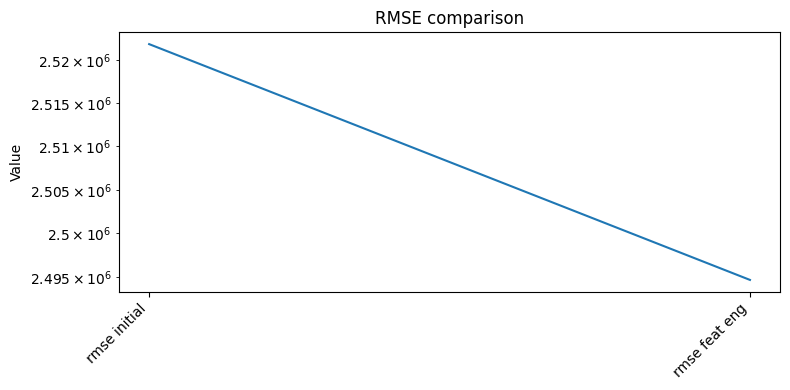

mape initial: 17.70
mape feat eng: 17.63


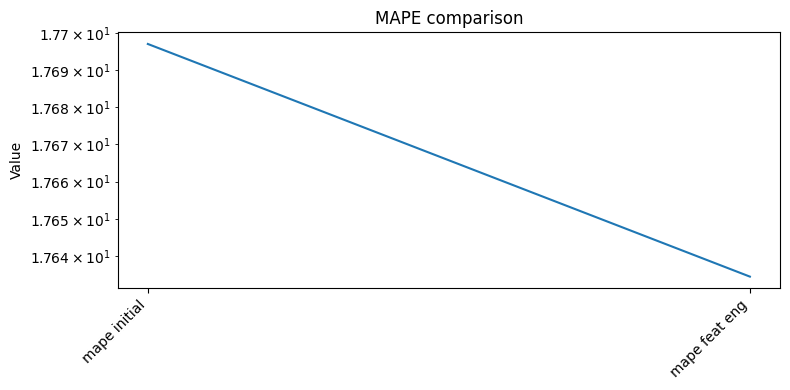

In [26]:
# train model on the transformed and original features and compare metrics
model.fit(X_train_pipe_total, y_train)
prediction = model.predict(X_test_pipe_total)

rmse = calculate_rmse(y_test, prediction)
mape = calculate_mape(y_test, prediction)

rmse_metrics['rmse feat eng'] = rmse
mape_metrics['mape feat eng'] = mape

display_metrics(rmse_metrics, 'RMSE comparison')
display_metrics(mape_metrics, 'MAPE comparison')

**Outcome:** We see improvement in the metrics using the generated features. Might be due to normalizing the distribution thanks to QuantileTransformer on originally skewed.

# 5. Feature selection

In [27]:
# Select most useful features using Sequential Feature Selection algorithm

sfs = SFS(RandomForestRegressor(random_state=RANDOM_STATE), k_features=10, forward=True, floating=False, scoring='neg_mean_squared_error', cv=2, n_jobs=-1)


sfs = sfs.fit(X_train_pipe_total, y_train)
top_sfs = sfs.k_feature_names_
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

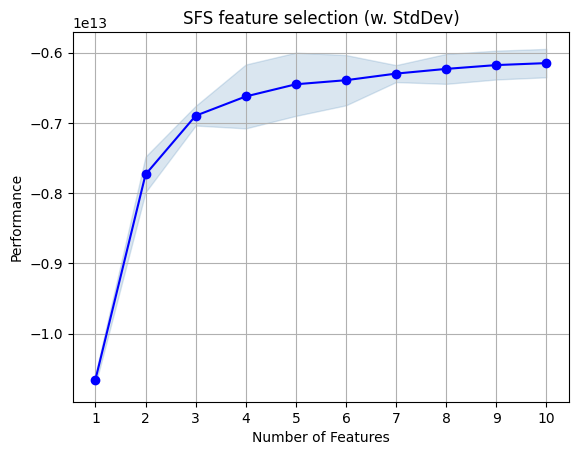

Selected features:  ['building_type_int', 'poly_features__total_area latitude', 'poly_features__latitude longitude', 'poly_features__latitude flats_count', 'poly_features__longitude^2', 'poly_features__ceiling_height^2', 'poly_features__flats_count floors_total', 'poly_features__latitude^3', 'poly_features__longitude^2 floors_total', 'quantile_features__total_area']


In [28]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('SFS feature selection (w. StdDev)')
plt.grid()
plt.show()

selected_features = list(sfs.k_feature_names_)
print('Selected features: ', selected_features)

rmse initial: 2521821.69
rmse feat eng: 2494661.72
rmse selected features: 2495592.82


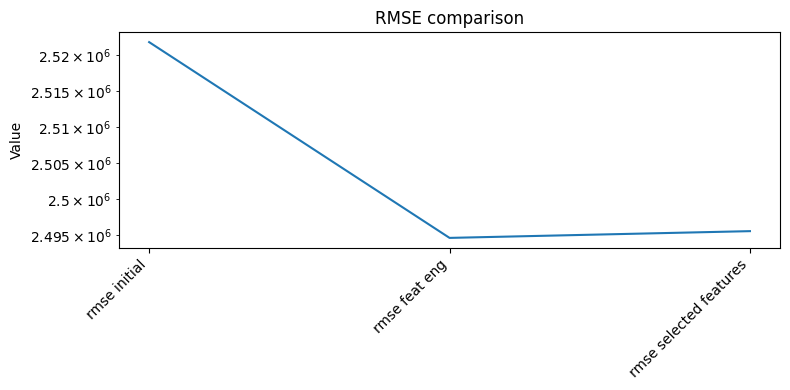

mape initial: 17.70
mape feat eng: 17.63
mape selected features: 17.80


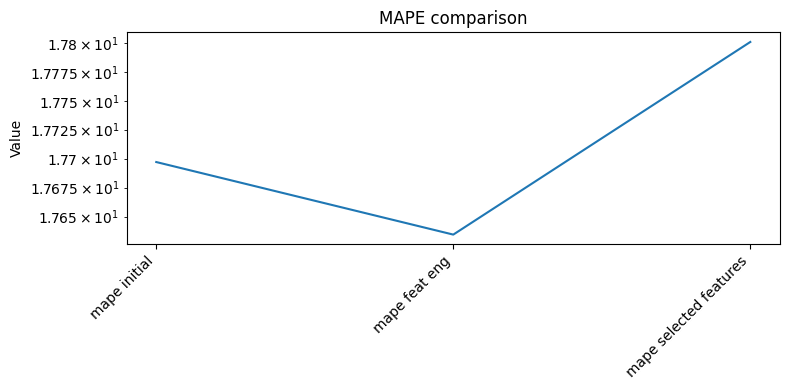

In [29]:
# train model on the selected features 
model.fit(X_train_pipe_total[selected_features], y_train)
prediction = model.predict(X_test_pipe_total[selected_features])

rmse = calculate_rmse(y_test, prediction)
mape = calculate_mape(y_test, prediction)

rmse_metrics['rmse selected features'] = rmse
mape_metrics['mape selected features'] = mape

display_metrics(rmse_metrics, 'RMSE comparison')
display_metrics(mape_metrics, 'MAPE comparison')

# 6. Hyperparameter selection

[I 2024-04-29 14:03:10,059] A new study created in memory with name: no-name-486cb3ff-6aec-4e78-819a-10f8d36c23f4
[I 2024-04-29 14:03:10,122] Trial 0 finished with value: 7652743071098.12 and parameters: {'n_estimators': 17, 'max_depth': 3, 'min_samples_split': 15}. Best is trial 0 with value: 7652743071098.12.
[I 2024-04-29 14:03:10,235] Trial 1 finished with value: 6401131919764.038 and parameters: {'n_estimators': 30, 'max_depth': 6, 'min_samples_split': 16}. Best is trial 1 with value: 6401131919764.038.


Running trial: 0
Running trial: 1
Running trial: 2


[I 2024-04-29 14:03:10,335] Trial 2 finished with value: 6592770040389.531 and parameters: {'n_estimators': 27, 'max_depth': 5, 'min_samples_split': 12}. Best is trial 1 with value: 6401131919764.038.
[I 2024-04-29 14:03:10,409] Trial 3 finished with value: 6469502628457.071 and parameters: {'n_estimators': 17, 'max_depth': 7, 'min_samples_split': 13}. Best is trial 1 with value: 6401131919764.038.
[I 2024-04-29 14:03:10,480] Trial 4 finished with value: 6496249262895.139 and parameters: {'n_estimators': 17, 'max_depth': 7, 'min_samples_split': 12}. Best is trial 1 with value: 6401131919764.038.


Running trial: 3
Running trial: 4
Running trial: 5


[I 2024-04-29 14:03:10,566] Trial 5 finished with value: 6769675787404.247 and parameters: {'n_estimators': 24, 'max_depth': 4, 'min_samples_split': 20}. Best is trial 1 with value: 6401131919764.038.
[I 2024-04-29 14:03:10,664] Trial 6 finished with value: 6336978931822.473 and parameters: {'n_estimators': 25, 'max_depth': 7, 'min_samples_split': 20}. Best is trial 6 with value: 6336978931822.473.
[I 2024-04-29 14:03:10,767] Trial 7 finished with value: 6309468601024.67 and parameters: {'n_estimators': 26, 'max_depth': 6, 'min_samples_split': 7}. Best is trial 7 with value: 6309468601024.67.


Running trial: 6
Running trial: 7
Running trial: 8


[I 2024-04-29 14:03:10,857] Trial 8 finished with value: 6278702836862.542 and parameters: {'n_estimators': 21, 'max_depth': 9, 'min_samples_split': 17}. Best is trial 8 with value: 6278702836862.542.
[I 2024-04-29 14:03:10,923] Trial 9 finished with value: 6808999880716.286 and parameters: {'n_estimators': 15, 'max_depth': 7, 'min_samples_split': 5}. Best is trial 8 with value: 6278702836862.542.
[I 2024-04-29 14:03:11,002] Trial 10 finished with value: 7454147219644.853 and parameters: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 8 with value: 6278702836862.542.


Running trial: 9
Running trial: 10
Running trial: 11


[I 2024-04-29 14:03:11,128] Trial 11 finished with value: 6403161806636.1045 and parameters: {'n_estimators': 22, 'max_depth': 10, 'min_samples_split': 7}. Best is trial 8 with value: 6278702836862.542.
[I 2024-04-29 14:03:11,244] Trial 12 finished with value: 6571605651658.501 and parameters: {'n_estimators': 21, 'max_depth': 9, 'min_samples_split': 8}. Best is trial 8 with value: 6278702836862.542.


Running trial: 12
Running trial: 13


[I 2024-04-29 14:03:11,396] Trial 13 finished with value: 6303965118096.317 and parameters: {'n_estimators': 29, 'max_depth': 9, 'min_samples_split': 9}. Best is trial 8 with value: 6278702836862.542.
[I 2024-04-29 14:03:11,541] Trial 14 finished with value: 6256164184284.737 and parameters: {'n_estimators': 30, 'max_depth': 9, 'min_samples_split': 17}. Best is trial 14 with value: 6256164184284.737.


Running trial: 14
Running trial: 15


[I 2024-04-29 14:03:11,629] Trial 15 finished with value: 6608360402082.987 and parameters: {'n_estimators': 14, 'max_depth': 9, 'min_samples_split': 17}. Best is trial 14 with value: 6256164184284.737.
[I 2024-04-29 14:03:11,701] Trial 16 finished with value: 6787978575151.989 and parameters: {'n_estimators': 10, 'max_depth': 8, 'min_samples_split': 18}. Best is trial 14 with value: 6256164184284.737.
[I 2024-04-29 14:03:11,819] Trial 17 finished with value: 6339164980991.156 and parameters: {'n_estimators': 22, 'max_depth': 8, 'min_samples_split': 14}. Best is trial 14 with value: 6256164184284.737.


Running trial: 16
Running trial: 17
Running trial: 18


[I 2024-04-29 14:03:11,961] Trial 18 finished with value: 6339315996311.633 and parameters: {'n_estimators': 28, 'max_depth': 10, 'min_samples_split': 18}. Best is trial 14 with value: 6256164184284.737.
[I 2024-04-29 14:03:12,070] Trial 19 finished with value: 6535703969758.189 and parameters: {'n_estimators': 19, 'max_depth': 8, 'min_samples_split': 10}. Best is trial 14 with value: 6256164184284.737.


Running trial: 19
Best Optuna parameters: {'n_estimators': 30, 'max_depth': 9, 'min_samples_split': 17}
rmse initial: 2521821.69
rmse feat eng: 2494661.72
rmse selected features: 2495592.82
rmse optuna: 2501232.53


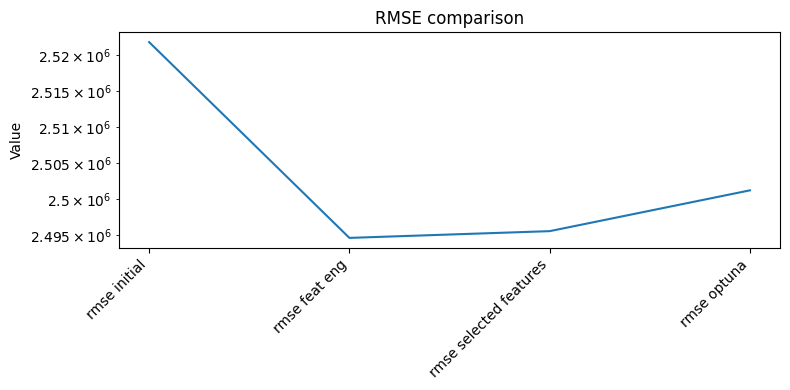

mape initial: 17.70
mape feat eng: 17.63
mape selected features: 17.80
mape optuna: 18.03


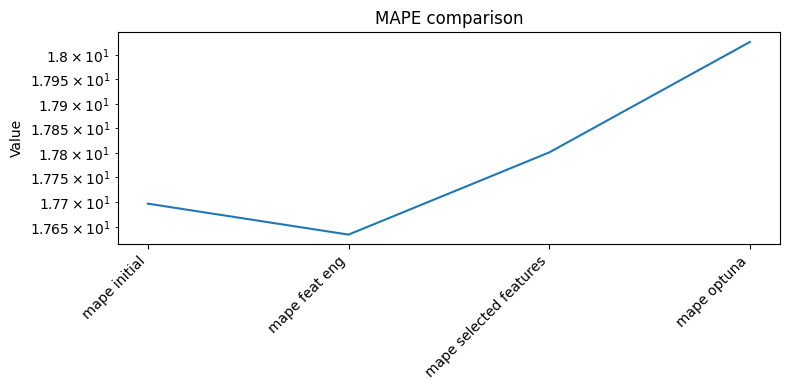

In [30]:
# Hyperparameter selection with Optuna

def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 10, 30)
        max_depth = trial.suggest_int('max_depth', 3, 10) 
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
        print('Running trial:', trial.number)
    
        model = RandomForestRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            min_samples_split=min_samples_split, 
            random_state=RANDOM_STATE 
        )
        model.fit(X_train_pipe_total[selected_features], y_train)
        prediction = model.predict(X_test_pipe_total[selected_features])
    
        mse = mean_squared_error(y_test, prediction)
        return mse




study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            )
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params


print('Best Optuna parameters:', best_params)

model = RandomForestRegressor(**best_params, random_state=RANDOM_STATE)

model.fit(X_train_pipe_total[selected_features], y_train)
prediction = model.predict(X_test_pipe_total[selected_features])   
        

rmse = calculate_rmse(y_test, prediction)
mape = calculate_mape(y_test, prediction)

rmse_metrics['rmse optuna'] = rmse
mape_metrics['mape optuna'] = mape

display_metrics(rmse_metrics, 'RMSE comparison')
display_metrics(mape_metrics, 'MAPE comparison')

# Conclusion:

We have managed to reduce the prediction error applying feature engineering.
The choice of transformations for feature engineering emerged from the relative small feature set and its skewed distribution.

Feature selection algorithm was used with Forward direction (by adding features one by one) for faster experimenting.
Hyperparameter selection was done with powerful Optuna library. (RandomizedSearchCV could be also used)

Feature selection reintroduced some error, potentially because the training of the model was done on a smaller feature subset.
Optuna hyperparameter selection worked on that reduced feature subset as well.

**Next iteration of this experiment** exercise could be testing Optuna on the complete feature engineered set, to minimize the error even more.